In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

In [82]:
def timeToDecimal(a):
    x = 0
    y = 0
    if len(a) == 4:
        x = float(a[0:1])
        y = float(a[2:])
        
    if len(a) == 5:
        x = float(a[0:2])
        y = float(a[3:])
    x *= 60
    z = (x+y)/1440
    return z

In [83]:
data = np.genfromtxt('ASTR19_F24_group_project_data.txt', dtype=[('day', 'i8'), ('time', 'U6'),('height', 'f8')])

day = []
time = []
height = []

for i in range (82):
    day.append(data[i][0])
    time.append(data[i][1])
    height.append(data[i][2])

real_Day = []
for i in range (len(time)):
    x = day[i] + timeToDecimal(time[i])
    x_1 = round(x, 3)
    real_Day.append(x_1)

Text(0, 0.5, 'tide height')

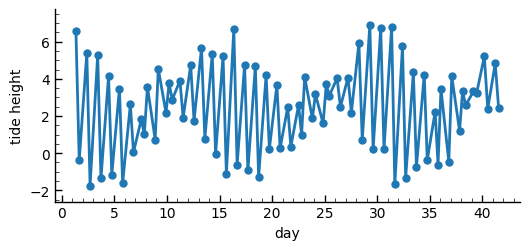

In [84]:
plt.plot(real_Day, height, '-o')
plt.xlabel("day")
plt.ylabel("tide height")

In [85]:
# Function to convert time to decimal day
def time_to_decimal(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours / 24 + minutes / 1440

# Parse data from the uploaded file
file_path = 'ASTR19_F24_group_project_data.txt'

# Read and process the data
days = []
times = []
heights = []

with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("#"):  # Ignore comments and empty lines
            cols = line.split()
            day = int(cols[0])
            time = cols[1]
            height = float(cols[2])
            days.append(day)
            times.append(time)
            heights.append(height)

# Convert days and times into a single decimal day
decimal_days = np.array([day + time_to_decimal(time) for day, time in zip(days, times)])
heights = np.array(heights)

In [88]:
def sinusoid(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset# Define the sinusoidal function

# RMS error as weights
weights = 1 / (0.25 ** 2)

# Initial guess for the parameters: amplitude, frequency, phase, offset
initial_guess = [3, 2 * np.pi / 1, 0, np.mean(heights)]  # Assumes one oscillation per day

# Fit the sinusoidal model with weights
params, covariance = curve_fit(
    sinusoid, decimal_days, heights, p0=initial_guess, sigma=np.full_like(heights, weights), absolute_sigma=True
)

# Extract fitted parameters
amplitude, frequency, phase, offset = params

# Generate the fitted curve
fitted_heights = sinusoid(decimal_days, amplitude, frequency, phase, offset)

In [89]:
# Print the fitted parameters with uncertainties
parameter_uncertainties = np.sqrt(np.diag(covariance))
print("Fitted Sinusoidal Parameters:")
print(f"Amplitude: {amplitude:.3f} ± {parameter_uncertainties[0]:.3f}")
print(f"Frequency: {frequency:.3f} (radians/day) ± {parameter_uncertainties[1]:.3f}")
print(f"Phase: {phase:.3f} ± {parameter_uncertainties[2]:.3f}")
print(f"Offset: {offset:.3f} ± {parameter_uncertainties[3]:.3f}")

Fitted Sinusoidal Parameters:
Amplitude: 2.968 ± 2.390
Frequency: 6.283 (radians/day) ± 0.075
Phase: -0.092 ± 1.975
Offset: 2.457 ± 1.942


In [90]:
plt.style.use("./astr19_matplotlib_defaults.txt")

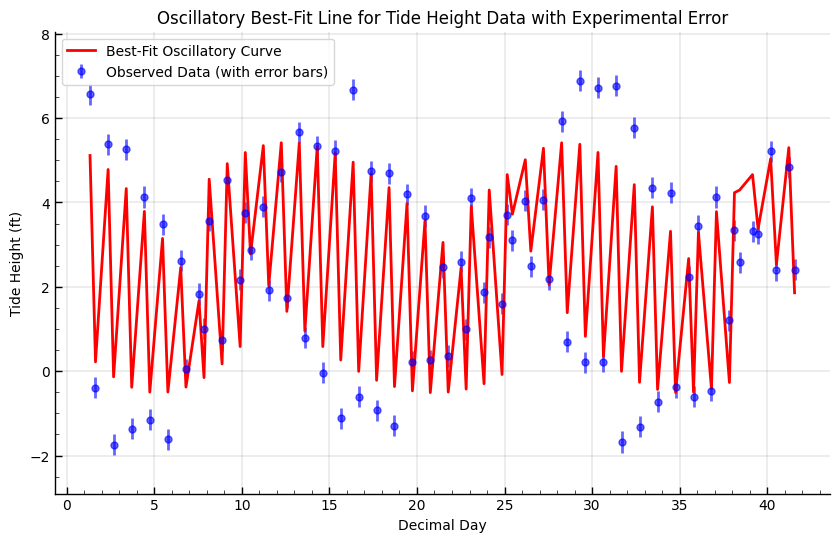

In [91]:
plt.figure(figsize=(10, 6))
plt.errorbar(decimal_days, heights, yerr=0.25, fmt='o', label="Observed Data (with error bars)", color="blue", alpha=0.6)
plt.plot(decimal_days, fitted_heights, label="Best-Fit Oscillatory Curve", color="red", linewidth=2)
plt.xlabel("Decimal Day")
plt.ylabel("Tide Height (ft)")
plt.title("Oscillatory Best-Fit Line for Tide Height Data with Experimental Error")
plt.legend()
plt.grid()
plt.show()

In [92]:
#Calculate residual by substracting sinusoid from data
residuals = heights - fitted_heights

In [93]:
plt.style.use("./astr19_matplotlib_defaults.txt")

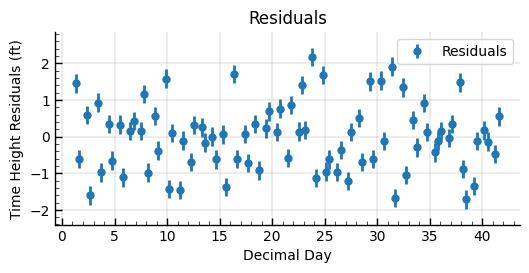

In [94]:
plt.errorbar(decimal_days,residuals,yerr=0.25,fmt='o',label='Residuals')
plt.xlabel('Decimal Day')
plt.ylabel('Time Height Residuals (ft)')
plt.title('Residuals')
plt.legend()
plt.grid()
plt.show()

In [95]:
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
print(f'Mean of residuals = {residual_mean}')
print(f'RMS of residual = {residual_std}')

Mean of residuals = -1.9827657131331097e-11
RMS of residual = 0.9135510541520397


In [96]:
def gaussian(x,mu,s):
    return 1./(2.*np.pi*s**2)**0.5 * np.exp(-0.5*((x-mu)/s)**2)

In [97]:
plt.style.use("./astr19_matplotlib_defaults.txt")

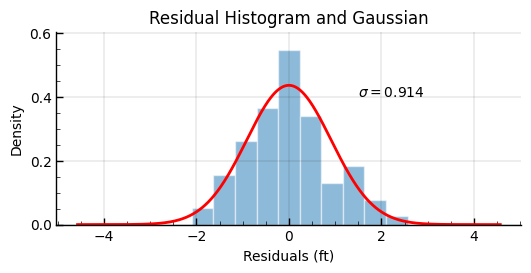

In [98]:
plt.hist(residuals,bins=15,range=(-3.5,3.5),alpha=0.5,edgecolor='white',density=True)
std_line = np.linspace(-5*residual_std,5*residual_std,1000)
plt.plot(std_line,gaussian(std_line,residual_mean,residual_std),color='red')
plt.xlabel('Residuals (ft)')
plt.ylabel('Density')
plt.title('Residual Histogram and Gaussian')
plt.text(1.5,0.4,r'$\sigma = 0.914$',color='black')
plt.grid()
plt.savefig('Residual_histogram.pdf',dpi=100,format='pdf',bbox_inches='tight')

In [99]:
squared_dev = sum([(i-residual_mean)**2 for i in residuals])
standard_dev = (squared_dev/len(residuals))**0.5
print(f'Standard deviation = {standard_dev}')
#Mathematical solution for standard deviation. Gives the same result as np.std(residuals)

Standard deviation = 0.9135510541520397


In [100]:
#To estimate the intrinsic scatter, use the following equation: (standard_dev)**2 = (yerr)**2 + (intrinsic_scatter)**2
#Rearrange the equation to solve for the intrinsic scatter. instrinsic_scatter = (standard_dev**2 - yerr**2)**0.5
yerr=0.25
intrinsic_scatter = (standard_dev**2 - yerr**2)**0.5
print(intrinsic_scatter)
if intrinsic_scatter > yerr:
    print(f'The scatter in data ({intrinsic_scatter}) is larger than the assumed expermiental error ({yerr})')
else:
    print(f'The assumed experimental error ({yerr}) is larger than the assumed scatter in the data ({intrinsic_scatter})')

0.878678285006693
The scatter in data (0.878678285006693) is larger than the assumed expermiental error (0.25)


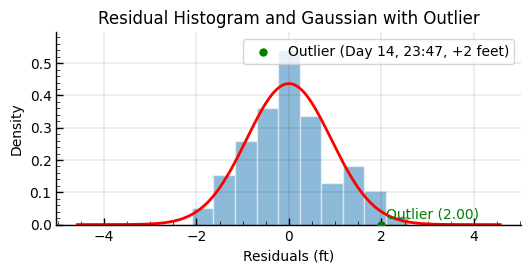

The probability of the Tsunami having a 2-feet outlier is 2.857800997784632%


In [106]:
# Step 1: Calculate the decimal day for Day 14 at 23:47
outlier_day = 14
outlier_time = "23:47"  # 23 hours 47 minutes
outlier_decimal_day = outlier_day + time_to_decimal(outlier_time)

# Step 2: Calculate the fitted height for this outlier
outlier_fitted_height = sinusoid(outlier_decimal_day, amplitude, frequency, phase, offset)

# Step 3: Define the outlier residual (2 feet above the fitted value)
outlier_residual = outlier_fitted_height + 2 - outlier_fitted_height

# Step 4: Add the outlier residual to the histogram
residuals_with_outlier = np.append(residuals, outlier_residual)  # Append the outlier to the residuals array

# Step 5: Plot the histogram with the outlier
plt.hist(residuals_with_outlier, bins=15, range=(-3.5, 3.5), alpha=0.5, edgecolor='white', density=True)

# Plot the Gaussian curve again
std_line = np.linspace(-5*residual_std, 5*residual_std, 1000)
plt.plot(std_line, gaussian(std_line, residual_mean, residual_std), color='red')

# Step 6: Add the outlier point to the histogram
plt.scatter(outlier_residual, 0, color='green', zorder=5, label="Outlier (Day 14, 23:47, +2 feet)")

# Annotate the outlier point
plt.text(outlier_residual + 0.1, 0.02, f'Outlier ({outlier_residual:.2f})', color='green')

# Labels and title
plt.xlabel('Residuals (ft)')
plt.ylabel('Density')
plt.title('Residual Histogram and Gaussian with Outlier')

# Add a legend
plt.legend()

# Show the plot
plt.grid()
plt.show()



def event_probability(x, mu, s):
    # outlier_residual in this context is the value of the event
    # residual_mean in this context is the gaussian mean
    # residual_std in this context is the gaussian standard deviation
    z = np.fabs((x - mu)/s)
    def zfunc(z):
        return 0.5*(1.0 + erf(z/2**0.5))

    #Return the probability of getting
    #an event of magnitude >=x
    return 1.0 - (zfunc(z) - zfunc(-1*z))
    
outlier_probability = event_probability(outlier_residual, residual_mean, residual_std)
print(f'The probability of the Tsunami having a 2-feet outlier is {outlier_probability * 100}%')